In [1]:
# install.packages(c('tidyverse', 'wesanderson', 'ggridges', 'ggthemes', 'reshape', 'lme4', 'Hmisc', 'afex'))

In [2]:
library(tidyverse)
library(wesanderson)
library(ggridges)
library(ggthemes)
library(reshape)
library(lme4)
library(Hmisc)
library(afex)

source("~/Dropbox/loki_0.5/analysis/functions/get_os.R")
source("~/Dropbox/loki_0.5/analysis/functions/median_cl_boot.R")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘ggridges’

The following object is masked from ‘package:ggplot2’:

    scale_discrete_manual


Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename

The following objects are masked from ‘package:tidyr’:

    expand, smiths

Loading required package: Matrix

Attaching package: ‘Matrix’

The following o

In [89]:
os <- get_os()
if (os == 'linux'){home <- '/home/krista/'
} else if(os == 'osx'){home <- '/Users/krista/'}

agg_data_path=paste0(home,'Dropbox/loki_0.5/analysis/aggregated_data/')
sim_data_path=paste0(home,'Dropbox/loki_0.5/data/simulated_data/')

In [90]:
reward_df <- read_csv(paste0(agg_data_path,"raw_reward_df.csv"), col_types=cols())
ls_df <- read_csv(paste0(sim_data_path,"learning_signals.csv"), col_types=cols())

(n_subjects = length(unique(reward_df$subj_id)))
(n_conditions = length(unique(reward_df$reward_code)))
n_trials_per_s = 400
reward_df$reward_code <- factor(reward_df$reward_code) #cast as factor

expected_rows = n_subjects * n_conditions * n_trials_per_s

paste0('number of rows is expected: ', nrow(reward_df) == expected_rows)

[1] 4

[1] 9

[1] "number of rows is expected: TRUE"

In [91]:
ls_df_sorted <- ls_df[order(ls_df$subj_id, ls_df$reward_code),] 
reward_df_sorted <- reward_df[order(reward_df$subj_id, reward_df$reward_code),] 

In [92]:
head(ls_df)

trial,epoch_trial,p_optimal,cpp,b_t0,b_t1,MC,H,signed_B_diff,reward_code,subj_id,accuracy,target_choice,correct_target_choice,lambda_val,ideal_B
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.65,0.05936247,0.0000000,0.0000000,0.5000000,0.0975,0.00000000,0,786,TRUE,0,0,10,0.00000000
1,1,0.65,0.05230506,0.0000000,0.0890437,0.6537310,0.0975,0.00000000,0,786,TRUE,0,0,10,-0.08904370
2,2,0.65,0.22832904,0.0000000,0.1628438,0.7243949,0.0975,0.08904370,0,786,TRUE,0,0,10,-0.16284385
3,3,0.65,0.07267309,0.9639528,0.4681554,0.5311390,0.0975,0.16284385,0,786,TRUE,0,0,10,0.49579737
4,4,0.65,0.87891172,0.4747848,0.5431428,0.6556834,0.0975,-0.49579737,0,786,TRUE,0,0,10,-0.06835797
5,5,0.65,0.09421732,4.0268209,1.3841358,0.3843557,0.0975,0.06835797,0,786,FALSE,1,0,10,2.64268507


In [93]:
reward_df_sorted['ideal_B'] = ls_df_sorted$ideal_B
reward_df_sorted['signed_B_diff'] = ls_df_sorted$ideal_B
reward_df_sorted['cpp'] = ls_df_sorted$cpp
reward_df_sorted['MC'] = ls_df_sorted$MC
reward_df_sorted['H'] = ls_df_sorted$H
reward_df_sorted['lambda_val'] = factor(ls_df_sorted$lambda_val)
reward_df_sorted['p_optimal'] = factor(ls_df_sorted$p_optimal)
# reward_df_sorted['subj_id'] = factor(reward_df_sorted$subj_id)

In [102]:
reward_df_sorted['cpp_shifted'] = reward_df_sorted %>% group_by(subj_id) %>% 
mutate(cpp_shifted=lag(cpp,1)) %>% pull(cpp_shifted)

reward_df_sorted['ideal_B_shifted'] = reward_df_sorted %>% group_by(subj_id) %>% 
mutate(ideal_B_shifted=lag(ideal_B,1)) %>% pull(ideal_B_shifted)

In [103]:
reward_df_sorted %>% group_by(subj_id) %>% summarise(n_nans = sum(is.na(cpp_shifted))) 
reward_df_sorted %>% group_by(subj_id) %>% summarise(n_nans = sum(is.na(ideal_B_shifted))) 
#there should now only be one na per person if shifted appropriately 

subj_id,n_nans
<dbl>,<int>
786,1
787,1
788,1
789,1


subj_id,n_nans
<dbl>,<int>
786,1
787,1
788,1
789,1


In [104]:
reward_df_clean = reward_df_sorted[complete.cases(reward_df_sorted), ]

In [105]:
table(reward_df_clean$reward_code, reward_df_clean$subj_id) #check that each subject has data for all conditions

   
    786 787 788 789
  0 391 393 395 396
  1 382 394 393 395
  2 384 391 382 396
  3 391 383 380 382
  4 383 386 393 383
  5 391 383 379 396
  6 384 394 387 374
  7 389 390 381 380
  8 367 394 383 393

In [106]:
names(reward_df_clean)

[1] "trial"             "subj_id"           "reward_code"      
 [4] "condition"         "run"               "LR_choice"        
 [7] "value_accuracy"    "value_LR_solution" "reward"           
[10] "cumulative_reward" "rt"                "total_trial_time" 
[13] "iti"               "cp_list"           "obs_cp_list"      
[16] "high_val_cue"      "high_p_cue"        "p_accuracy"       
[19] "p_LR_solution"     "p_id_solution"     "id_choice"        
[22] "stim_duration"     "stim_onset"        "stim_offset"      
[25] "abs_response_time" "epoch_length"      "epoch_trial"      
[28] "epoch_number"      "ideal_B"           "signed_B_diff"    
[31] "cpp"               "MC"                "H"                
[34] "lambda_val"        "p_optimal"         "cpp_shifted"      
[37] "ideal_B_shifted"

In [108]:
#sanity check
cpp_lm = lm(cpp_shifted ~ lambda_val*p_optimal, data = reward_df_clean)
B_lm = lm(ideal_B_shifted ~ lambda_val*p_optimal, data = reward_df_clean)

summary(cpp_lm)
summary(B_lm)


Call:
lm(formula = cpp_shifted ~ lambda_val * p_optimal, data = reward_df_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.17051 -0.09499 -0.07250 -0.00258  0.89116 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 0.218466   0.004762  45.881  < 2e-16 ***
lambda_val20               -0.090549   0.006746 -13.423  < 2e-16 ***
lambda_val30               -0.113768   0.006758 -16.835  < 2e-16 ***
p_optimal0.75              -0.019764   0.006777  -2.917  0.00354 ** 
p_optimal0.85              -0.035221   0.006773  -5.200 2.02e-07 ***
lambda_val20:p_optimal0.75  0.029569   0.009585   3.085  0.00204 ** 
lambda_val30:p_optimal0.75  0.016338   0.009590   1.704  0.08848 .  
lambda_val20:p_optimal0.85  0.018742   0.009586   1.955  0.05059 .  
lambda_val30:p_optimal0.85  0.026334   0.009597   2.744  0.00608 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.189 on 13929 d


Call:
lm(formula = ideal_B_shifted ~ lambda_val * p_optimal, data = reward_df_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8864 -0.7313  0.0593  0.8318  4.3354 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 0.35843    0.03170  11.308  < 2e-16 ***
lambda_val20                0.09506    0.04490   2.117   0.0343 *  
lambda_val30                0.11321    0.04498   2.517   0.0119 *  
p_optimal0.75               0.09903    0.04511   2.195   0.0282 *  
p_optimal0.85               0.38280    0.04509   8.490  < 2e-16 ***
lambda_val20:p_optimal0.75  0.15425    0.06380   2.418   0.0156 *  
lambda_val30:p_optimal0.75  0.27448    0.06384   4.300 1.72e-05 ***
lambda_val20:p_optimal0.85  0.25000    0.06381   3.918 8.98e-05 ***
lambda_val30:p_optimal0.85  0.40201    0.06388   6.293 3.21e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.258 on 13929 degrees of freedo

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


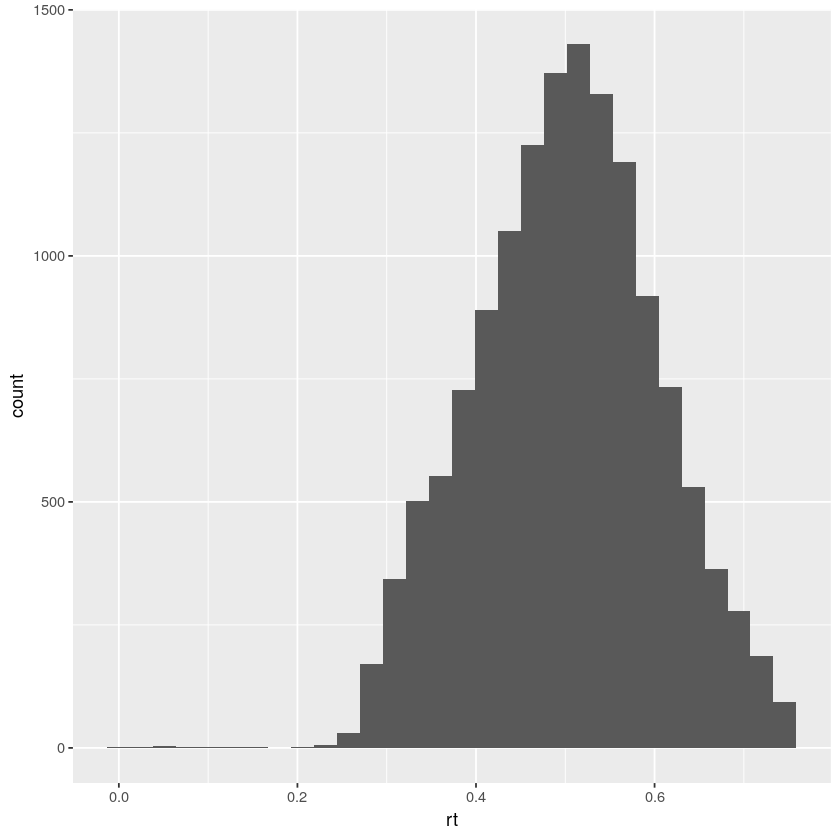

In [110]:
ggplot(reward_df_clean, aes(x=rt)) + geom_histogram() #pretty close to normal

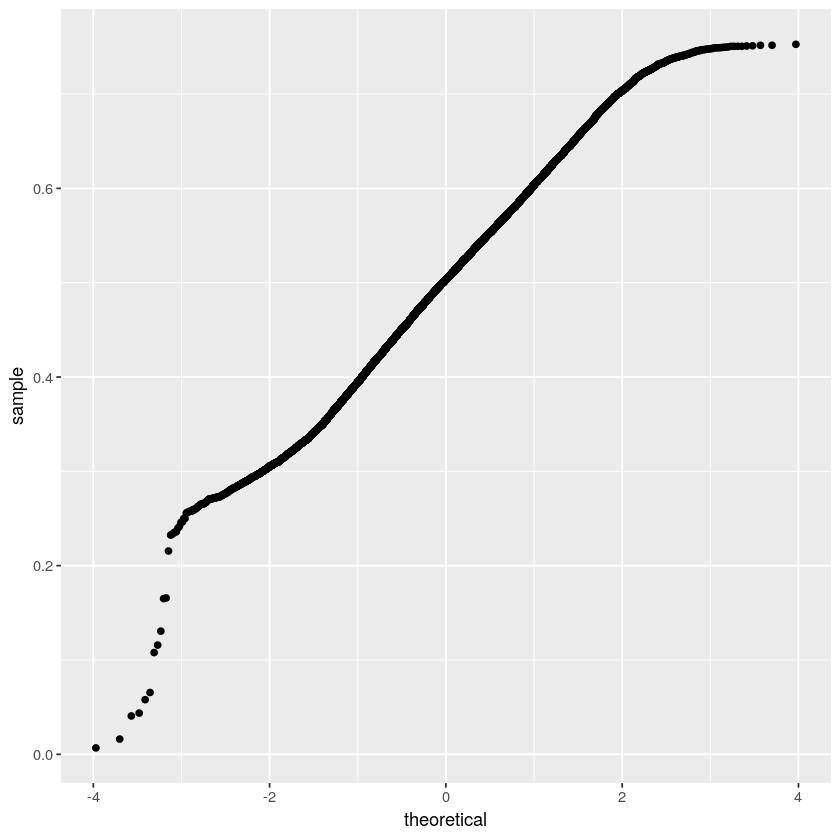

In [111]:
ggplot(reward_df_clean, aes(sample=rt)) + geom_point(stat = "qq") #pretty close to normal

In [112]:
#conduct this analysis for each person in a loop or using piping 
cpp_rt_lm = lmer(rt ~ cpp_shifted + (1|subj_id), data = reward_df_clean)
B_rt_lm = lmer(rt ~ ideal_B_shifted + (1|subj_id), data = reward_df_clean)

summary(cpp_rt_lm)
summary(B_rt_lm)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rt ~ cpp_shifted + (1 | subj_id)
   Data: reward_df_clean

REML criterion at convergence: -26330.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3678 -0.7150 -0.0814  0.6455  3.2634 

Random effects:
 Groups   Name        Variance Std.Dev.
 subj_id  (Intercept) 0.001888 0.04345 
 Residual             0.008828 0.09396 
Number of obs: 13938, groups:  subj_id, 4

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  5.037e-01  2.175e-02  3.004e+00  23.162 0.000175 ***
cpp_shifted -1.945e-02  4.105e-03  1.393e+04  -4.739 2.17e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cpp_shifted -0.027

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rt ~ ideal_B_shifted + (1 | subj_id)
   Data: reward_df_clean

REML criterion at convergence: -26340.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4051 -0.7145 -0.0845  0.6488  3.1959 

Random effects:
 Groups   Name        Variance Std.Dev.
 subj_id  (Intercept) 0.001887 0.04344 
 Residual             0.008819 0.09391 
Number of obs: 13938, groups:  subj_id, 4

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)     4.983e-01  2.174e-02 3.002e+00  22.919 0.000181 ***
ideal_B_shifted 3.726e-03  6.162e-04 1.393e+04   6.047 1.51e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
idl_B_shftd -0.020

In [120]:
confint(cpp_rt_lm, level=0.95, method="boot", nsim = 5000, type = 'parametric')
confint(B_rt_lm, level=0.95, method="boot", nsim = 5000)

Computing bootstrap confidence intervals ...

14 warning(s): Model failed to converge with max|grad| = 0.00213482 (tol = 0.002, component 1) (and others)



,2.5 %,97.5 %
.sig01,0.01193202,0.07706466
.sigma,0.09283470,0.09507914
(Intercept),0.46047817,0.54573384
cpp_shifted,-0.02769288,-0.01108189


Computing bootstrap confidence intervals ...

17 warning(s): Model failed to converge with max|grad| = 0.00213537 (tol = 0.002, component 1) (and others)



,2.5 %,97.5 %
.sig01,0.01143398,0.077129634
.sigma,0.09279717,0.095020556
(Intercept),0.45577778,0.541661918
ideal_B_shifted,0.00251213,0.004966427


In [28]:
cpp_acc_log = glmer(p_accuracy ~ cpp_shifted + (1|subj_id), data = reward_df_clean, family='binomial')
B_acc_log = glmer(p_accuracy ~ ideal_B_shifted + (1|subj_id), data = reward_df_clean, family='binomial')

summary(cpp_acc_log)
summary(B_acc_log)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: p_accuracy ~ cpp + (1 | subj_id)
   Data: reward_df_clean

     AIC      BIC   logLik deviance df.resid 
 18816.8  18839.5  -9405.4  18810.8    13939 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3412 -1.1671  0.7523  0.8420  1.1715 

Random effects:
 Groups  Name        Variance Std.Dev.
 subj_id (Intercept) 0.0374   0.1934  
Number of obs: 13942, groups:  subj_id, 4

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.39603    0.09903   3.999 6.36e-05 ***
cpp         -0.41905    0.08808  -4.757 1.96e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
cpp -0.128

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: p_accuracy ~ ideal_B + (1 | subj_id)
   Data: reward_df_clean

     AIC      BIC   logLik deviance df.resid 
 18568.8  18591.5  -9281.4  18562.8    13939 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0101 -1.1060  0.6895  0.8314  1.7561 

Random effects:
 Groups  Name        Variance Std.Dev.
 subj_id (Intercept) 0.03849  0.1962  
Number of obs: 13942, groups:  subj_id, 4

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.18410    0.10004    1.84   0.0657 .  
ideal_B      0.22257    0.01371   16.23   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
ideal_B -0.090

In [29]:
confint(cpp_acc_log, level=0.95, method="boot")
confint(B_acc_log, level=0.95, method="boot")

Computing bootstrap confidence intervals ...

6 message(s): boundary (singular) fit: see ?isSingular
2 warning(s): Model failed to converge with max|grad| = 0.012332 (tol = 0.001, component 1) (and others)



,2.5 %,97.5 %
.sig01,0.02386729,0.3043555
(Intercept),0.19888078,0.5904220
cpp,-0.59879685,-0.2445898


Computing bootstrap confidence intervals ...

4 message(s): boundary (singular) fit: see ?isSingular



,2.5 %,97.5 %
.sig01,0.03278252,0.3151235
(Intercept),-0.01846888,0.3820776
ideal_B,0.19614511,0.2513866


In [33]:
agg_data_path=paste0(home,'Dropbox/loki_0.5/analysis/aggregated_data/')
write.csv(reward_df_clean, file = paste0(agg_data_path, "reward_ls_combined.csv"))